# Computing the Value of Information for supporting system design

Probably investigate reducing uncertainty in mean load as that is nice and simple - first perfect information, then imperfect information

In [ ]:
from tqdm.auto import tqdm
import numpy as np
from numpy import random
from scipy import stats

from models import sample_posterior
from models import run_model
from functools import partial
from utils import get_Gurobi_WLS_env, fmt_design_results

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
env = get_Gurobi_WLS_env(silence=True)
run_model = partial(run_model, env=env)
random.seed(42)

In [ ]:
solar_years = range(2012,2018)
load_years = range(2012,2018)

load_mean = 100
load_std = 10
msr_error = 0.025

In [4]:
def sample_load_prior(nsamples):
    thetas = stats.truncnorm.rvs(-2, 2, loc=load_mean, scale=load_std, size=nsamples)
    zs = stats.norm.rvs(loc=thetas, scale=thetas*msr_error)
    return thetas, zs

def build_scenarios(load_samples):

    n = len(load_samples)

    scenarios = {
        'solar_year': random.choice(solar_years, n),
        'load_year': random.choice(load_years, n),
        'mean_load': load_samples,
        'battery_efficiency': stats.truncnorm.rvs(-2, 2, loc=0.9, scale=0.05, size=n),
        'battery_cost': stats.truncnorm.rvs(-2, 2, loc=70, scale=5, size=n),
    }

    return scenarios

Prior

In [5]:
tsamples = 50
thetas, zs = sample_load_prior(tsamples)
print(thetas[:10])
print(zs[:10])

[118.178275   111.82480165  97.3176859  109.08717567  93.94049894
 107.23527566  94.00726419  89.77749988 108.80969993 100.15796422]
[119.9430033  112.88666389  86.6341773  107.67095085 100.98107113
 108.65336215  90.89684086  90.16216506 103.57371518  91.42740271]


In [6]:
scenarios = build_scenarios(thetas)

prior_results = run_model(
    solar_capacity=None,
    battery_capacity=None,
    **scenarios
)

print(fmt_design_results(prior_results))

Parameter         Unit      Value
----------------  ------  -------
Solar capacity    kWp       789.2
Battery capacity  kWh       349.9
Total cost        £k/yr     144.8
CAPEX             £k/yr      83.9
OPEX              £k/yr      61


Could do VoI with discrete design options (i.e. not On-Policy VoI), but is it that informative? Is it worth it?

In [7]:
...

Ellipsis

Perfect information - ToDo

In [8]:
results = []

for theta in tqdm(thetas, desc='Solving posterior problems'):

    scenario = build_scenarios([theta])

    post_results = run_model(
        solar_capacity=None,
        battery_capacity=None,
        **scenario
    )

    results.append(post_results)

Solving posterior problems:   0%|          | 0/50 [00:00<?, ?it/s]

In [9]:
print(([r['total'] for r in results]))
print(np.mean([r['total'] for r in results]))

[172129.09283265498, 160463.62200688763, 137053.60348453547, 152038.36211753392, 125300.58086477843, 152507.8880963123, 126130.31611961438, 123050.38055807336, 155715.21115587707, 139985.1555571311, 160675.60614201537, 124005.09554841758, 138360.5273694502, 112824.0450084616, 134149.13248161698, 130329.14659577837, 155136.74621123602, 154530.35773938845, 127468.98918574362, 150099.92885490364, 136990.50074576563, 111403.23181848395, 104796.25607545266, 128620.16273168055, 146739.6985095526, 110383.94199189846, 120711.25093623031, 120697.08899700963, 153419.4307755623, 126078.37423654173, 148162.95427217928, 167928.36088882643, 158016.08974190007, 163409.47635365388, 146912.23706608266, 120036.39828799113, 147970.21823319112, 133982.57981672086, 159635.77401440468, 140937.32841943298, 150430.0646884095, 157465.50338637538, 135597.56347431734, 112831.32340378105, 155493.7954513287, 139926.0345650167, 116213.9903949461, 141851.91411034146, 133963.98125648987, 113351.67326869137]
138718.21

In [10]:
prior_cost = prior_results['total']
preposterior_cost = np.mean([r['total'] for r in results])
print(f'Prior cost: {prior_cost}')
print(f'Posterior cost: {preposterior_cost}')
print(f'VoI: {prior_cost - preposterior_cost}')
voi_percent = (prior_cost - preposterior_cost) / prior_cost * 100
print(f'VoI percent: {voi_percent:.2f}%')

Prior cost: 144824.4042286907
Posterior cost: 138718.21971685337
VoI: 6106.184511837317
VoI percent: 4.22%


*Should I take the other uncertainties out for the initial calcs to make the EVPI computations simpler? I.e. not need an expectation per z (actual perfect information, not partial perfect information). Then I could add them back in for the EVII calcs*

Imperfect information

In [18]:
vsamples = 10
z = zs[10]
print(z)
samples = sample_posterior(z=z, nsamples=vsamples, msr_error=msr_error)
print(samples)

114.99029560893355
[104.761 116.506 117.724 109.275 109.156 113.596 111.91  116.569 106.785
 109.264]


Text(0, 0.5, '')

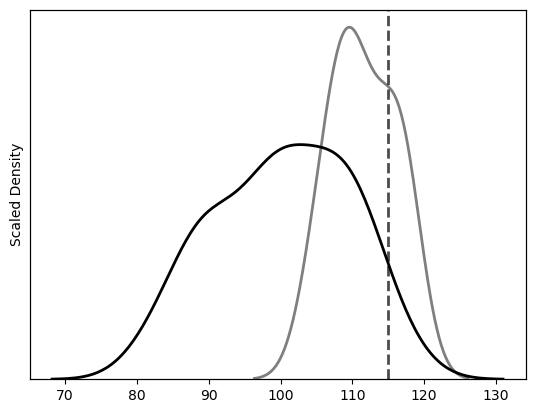

In [19]:
fig, ax = plt.subplots()

sns.kdeplot(thetas,label='prior',color='k',lw=2)

ymax = ax.get_ylim()[1]*1.5
plt.vlines(z,0,ymax,label='Measurement',color='k', alpha=0.7, ls='--', lw=2)

ax2 = ax.twinx()
sns.kdeplot(
    samples,
    #cut=0,
    label='posterior',
    ax=ax2, c='k', alpha=0.5, lw=2
)

ax.set_ylim(0,ymax)
ax.get_yaxis().set_ticks([])
ax.yaxis.set_label_text('Scaled Density')
ax2.get_yaxis().set_ticks([])
ax2.yaxis.set_label_text('')

In [13]:
results = []

for theta,z in tqdm(zip(thetas, zs), total=tsamples, desc='Solving posterior problems'):

    varthetas = sample_posterior(z=z, nsamples=vsamples, msr_error=msr_error)

    scenarios = build_scenarios(varthetas)

    post_results = run_model(
        solar_capacity=None,
        battery_capacity=None,
        **scenarios
    )

    results.append(post_results)

Solving posterior problems:   0%|          | 0/50 [00:00<?, ?it/s]

Optimization potentially failed: 
Status: aborted
Termination condition: user_interrupt
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: 11




Interrupt request received


AttributeError: Underlying model not optimized.

In [ ]:
print(([r['total'] for r in results]))
print(np.mean([r['total'] for r in results]))

In [ ]:
prior_cost = prior_results['total']
preposterior_cost = np.mean([r['total'] for r in results])
print(f'Prior cost: {prior_cost}')
print(f'Posterior cost: {preposterior_cost}')
print(f'VoI: {prior_cost - preposterior_cost}')
voi_percent = (prior_cost - preposterior_cost) / prior_cost * 100
print(f'VoI percent: {voi_percent:.2f}%')